### Initial package imports

In [3]:
import pandas as pd
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt

## Initial files being read in and dataset creation

In [4]:
pd.set_option('display.float_format', '{:.6f}'.format)
# Read the data
main_df = pd.read_csv('Data/Cleaned_Indices_Assignment1.csv', sep=';')

# Read the interest rate data
#interest_rate_df = pd.read_csv('Data/ECB_Rates_2012_to_2022.csv', sep=';')
interest_rate_bond_df = pd.read_csv('Data/ECB_Data_10yr_Treasury_bond.csv', sep=',')

# Convert date columns to datetime format for proper merging
main_df['Date'] = pd.to_datetime(main_df['Date'], format='%d-%m-%Y')
#interest_rate_df['Date'] = pd.to_datetime(interest_rate_df['Date'], format='%d-%m-%Y')
#gov_bond_investment_df['Date'] = pd.to_datetime(gov_bond_investment_df['Date'], format='%Y-%m-%d')
interest_rate_bond_df['Date'] = pd.to_datetime(interest_rate_bond_df['Date'], format='%Y-%m-%d')

# Merge the dataframes on the Date column
main_df = pd.merge(main_df, interest_rate_bond_df, on='Date', how='left')
#main_df = pd.merge(main_df, gov_bond_investment_df, on='Date', how='left')

# Remove rows where the bond does not have a yield curve spot rate (Market closed?)
main_df = main_df.dropna(axis=0, subset=['Yield curve spot rate, 10-year maturity - Government bond'])

# Filter the dataframe to start from 2012-01-04
main_df = main_df[main_df['Date'] >= '2012-01-04']
main_df = main_df.reset_index(drop=True)

### government bond column

In [5]:
	
# Add a column for the interest bond value per day
days_per_annum = 365
interest_bond = 1500000

# Initialize the arrays with appropriate lengths matching the DataFrame
interest_bond_vector = np.zeros(len(main_df))
interest_bond_profit_vector = np.zeros(len(main_df))
interest_bond_loss_vector = np.zeros(len(main_df))
daily_rates = np.zeros(len(main_df))

# Set initial value
interest_bond_vector[0] = interest_bond


# Calculate bond values day by day based on the daily yield rate
for i in range(len(main_df)):
    # Adding 1.5% to account for the credit risk spread
    daily_rate = (((main_df['Yield curve spot rate, 10-year maturity - Government bond'].iloc[i] + 1.5) / (days_per_annum)) * (7/5)) / 100
    daily_rates[i] = daily_rate
    
    if i > 0:
        previous_value = interest_bond_vector[i-1]
        current_value = previous_value * (1 + daily_rate)
        interest_bond_vector[i] = current_value
        
        # Calculate change, profit/loss and return
        change = current_value - previous_value
        interest_bond_profit_vector[i] = change
        interest_bond_loss_vector[i] = -change

# Add vectors to the dataframe
main_df['Interest_Bond'] = interest_bond_vector
main_df['Interest_Bond_Profit'] = interest_bond_profit_vector
main_df['Interest_Bond_Loss'] = interest_bond_loss_vector
main_df['Interest_Bond_daily_rate'] = daily_rates




## Portfolio details

### details

#### Instruments:
- **S&P500**
- **DAX40**
- **NIKKEI**
- **EU Government Bond (10-year maturity, AAA-rated)**

#### Invested amount:
- **10,000,000 EURO**

#### Period:
- **01/01/2012 - 31/12/2022**

#### Weights:
- **S&P500**: 0.4  
- **DAX40**: 0.3  
- **NIKKEI**: 0.15  
- **EU Government Bond**: 0.15  

#### Measures:
- **Value at Risk (VaR)**: 1, 5, 10 days  
- **Expected Shortfall (ES)**  



### weights and currency correction


In [6]:
# initial investment 
weights = {
    'S&P500': 0.4,
    'DAX40': 0.3,
    'NIKKEI': 0.15,
    'EU-BOND': 0.15,
}

starting_investment = 10000000  # 10 million euros
starting_date = '2012-01-04'

# Filter the main_df for the starting date
starting_row = main_df[main_df['Date'] == starting_date]

# Extract the exchange rates for the starting date
usd_to_eur = float(starting_row['USD/EUR'].iloc[0])
jpy_to_eur = float(starting_row['JPY/EUR'].iloc[0])

# Calculate the invested amounts
invested_amount_SP500 = starting_investment * weights['S&P500'] / usd_to_eur
invested_amount_DAX40 = starting_investment * weights['DAX40']
invested_amount_NIKKEI = starting_investment * weights['NIKKEI'] / jpy_to_eur
invested_amount_EU_BOND = starting_investment * weights['EU-BOND']

invested_amounts = [
    invested_amount_SP500, #in USD
    invested_amount_DAX40, #in EUR
    invested_amount_NIKKEI, #in JPY
    invested_amount_EU_BOND #in EUR
]

print(invested_amounts)

[5177993.527508091, 3000000.0, 148957298.90764648, 1500000.0]


### Returns Portfolio 

In [7]:
#create a column for the invested amount in the SP500 and multiply by the return of the next day 

main_df['SP500_Investment'] = invested_amount_SP500 * (1 + main_df['C_S&P500_Returns']).cumprod()
main_df['DAX40_Investment'] = invested_amount_DAX40 * (1 + main_df['C_Dax40_Returns']).cumprod()
main_df['NIKKEI_Investment'] = invested_amount_NIKKEI * (1 + main_df['C_Nikkei_Returns']).cumprod()
main_df['EU_BOND_Investment'] = main_df['Interest_Bond']

## Methods input values 

### time window

### Expected returns (daily) --> Action make into method with time window as input parameter

In [8]:
def calculate_expected_daily_returns(time_window, current_date):
    expected_returns = {
        'Date': current_date,
        'SP500_Mean_Return': time_window['C_S&P500_Returns'].mean(),
        'DAX40_Mean_Return': time_window['C_Dax40_Returns'].mean(),
        'NIKKEI_Mean_Return': time_window['C_Nikkei_Returns'].mean(),
        'EU_Bond_Mean_Return': time_window['Interest_Bond_Profit'].mean(),
        'Portfolio_Mean_Return': (
            weights['S&P500'] * time_window['C_S&P500_Returns'].mean() +
            weights['DAX40'] * time_window['C_Dax40_Returns'].mean() +
            weights['NIKKEI'] * time_window['C_Nikkei_Returns'].mean() +
            weights['EU-BOND'] * time_window['Interest_Bond_Profit'].mean()
        )
    }
    return expected_returns

In [9]:
# Create Portfolio_loss column as the sum of the 4 loss components
main_df['Portfolio_loss'] = (
    main_df['C_S&P500_Loss'] + 
    main_df['C_Dax40_Loss'] + 
    main_df['C_Nikkei_Loss'] + 
    main_df['Interest_Bond_Loss']
)

In [10]:
loss_values = main_df['Portfolio_loss'].values

# Calculate and print the minimum, maximum, and mean of portfolio loss values
min_loss = np.nanmin(loss_values)
max_loss = np.nanmax(loss_values)
mean_loss = np.nanmean(loss_values)

print(f"Portfolio Loss Statistics:")
print(f"Minimum Loss: {min_loss:.4f}")
print(f"Maximum Loss: {max_loss:.4f}")
print(f"Mean Loss: {mean_loss:.4f}")

# Also print the number of valid loss values (non-NaN)
valid_count = np.sum(~np.isnan(loss_values))
print(f"Number of valid loss values: {valid_count} out of {len(loss_values)}")

Portfolio Loss Statistics:
Minimum Loss: -1249.7677
Maximum Loss: 1461.1150
Mean Loss: -146.1673
Number of valid loss values: 2804 out of 2805


In [11]:
def calculate_daily_loss_variables(time_window, current_date):
    # Calculate the mean and standard deviation of portfolio loss from the time windows
    loss_dict = {
        "Date": current_date,
        "Portfolio_mean_loss": np.nanmean(time_window['Portfolio_loss']),
        "Portfolio_std_loss": np.nanstd(time_window['Portfolio_loss'])
    }
    return loss_dict

### Variances --> Action make into method with time window as input parameter

### Covariance matrix --> action make into method with variable time window

### Portfolio variance & standard deviation

In [12]:
def calculate_variance_return(window, current_date, weights):
    """
    Calculate the variance returns for each index and the portfolio variance and volatility.
    """
    variance_return = {
        'Date': current_date,
        'SP500_Var_Return': window['C_S&P500_Returns'].var(),
        'DAX40_Var_Return': window['C_Dax40_Returns'].var(),
        'NIKKEI_Var_Return': window['C_Nikkei_Returns'].var(),
        'EU_Bond_Var_Return': window['Interest_Bond_daily_rate'].var()
    }

    weights = np.array([weights['S&P500'], weights['DAX40'], weights['NIKKEI'], weights['EU-BOND']])

    # Calculate the covariance matrix for the returns in the window
    covariance_matrix = window[['C_S&P500_Returns', 'C_Dax40_Returns', 'C_Nikkei_Returns', 'Interest_Bond_daily_rate']].cov()

    # Calculate the portfolio variance using the covariance matrix and weights
    portfolio_variance = np.dot(weights.T, np.dot(covariance_matrix.values, weights))
    portfolio_volatility = np.sqrt(portfolio_variance)

    # Add portfolio variance and volatility to the variance_return dictionary
    variance_return['Portfolio_Variance'] = portfolio_variance
    variance_return['Portfolio_Volatility'] = portfolio_volatility

    return variance_return

# Value at Risk (VaR)

In [13]:
def VaR(alpha, r= 0, s= 1, df= 0):
    """
    Purpose:
        Get the VaR of the normal model

    Inputs:
        alpha   double, level
        r       double, expected return
        s       double, volatility
        df      (optional) double, degrees of freedom for student-t

    Return value:
        dVaR    double, VaR
    """
    if (df == 0):
        dVaR0= st.norm.ppf(alpha)
        dVaR = r + s*dVaR0
    else:
        dVaR0= st.t.ppf(alpha, df= df)

        dS2t= df/(df-2)

        c = s / np.sqrt(dS2t)
        dVaR= r + c*dVaR0
    return dVaR

# Expected Shortfall (ES) 

In [14]:
def ES(alpha, r= 0, s= 1, df= 0):
    """
    Purpose:
        Get the ES of the normal/student model

    Inputs:
        alpha   double, level
        r       double, expected return
        s       double, volatility
        df      (optional, default= 0/normal) double, df

    Return value:
        dES     double, ES
    """
    if (df == 0):
        dVaR0= st.norm.ppf(alpha)
        dES0= st.norm.pdf(dVaR0) / (1-alpha)
        dES= r + s*dES0
    else:
        dVaR0= st.t.ppf(alpha, df= df)
        dES0= st.t.pdf(dVaR0, df= df)*((df + dVaR0**2)/(df-1)) / (1-alpha)

        dS2t= df/(df-2)
        c= s / np.sqrt(dS2t)
        dES= r + c*dES0
    return dES

## performing different methods

write method for variance covariance where the sample period is an input parameter alongside other parameters that are needed for the calculation

## 1. var/cov multivar normal dist & T-distribution

4 code blocks with functions to calculate components of Var/cov method, 1 code block with for loop to iterate through set window for daily VaR and ES

## Main method

In [28]:
def main():
    # Initialize lists to store results
    mean_losses = []
    portfolio_std_losses = [] # Store standard dev of losses
    VaR_results = []
    ES_results = []  # List to store ES results
    time_window = main_df[(main_df['Date'] >= '2012-01-04') & (main_df['Date'] <= '2021-12-31')]

    vAlpha= [.95, .99]
    vAlpha= np.array(vAlpha)

    # Iterate through the DataFrame with a rolling window of 500 days
    sample_size = 500
    degrees_of_freedom = [0, 3, 4, 5, 6] # Normal (0) and T-distributions

    for i in range(sample_size, len(time_window)):
        # Extract the window of 500 days
        window = time_window.iloc[i - sample_size:i]
        current_date = time_window.iloc[i]['Date']
        
        # Calculate mean loss and portfolio std dev of LOSS
        loss_stats = calculate_daily_loss_variables(window, current_date)
        mean_loss = loss_stats["Portfolio_mean_loss"]
        portfolio_std_loss = loss_stats["Portfolio_std_loss"] # Use std dev of loss
        
        # Append the results to the lists
        mean_losses.append(mean_loss)
        portfolio_std_losses.append(portfolio_std_loss)
        
        # Dictionaries to hold results for the current date
        var_row = {'Date': current_date}
        es_row = {'Date': current_date}
        
        # Calculate VaR and ES for each degree of freedom using mean and std dev of LOSS
        for df in degrees_of_freedom:
            # Use portfolio_std_loss (std dev of loss) as 's' parameter
            current_var = VaR(vAlpha, mean_loss, portfolio_std_loss, df)
            current_es = ES(vAlpha, mean_loss, portfolio_std_loss, df)
            
            # Determine the key name (e.g., 'VaR Normal', 'VaR T3')
            var_key = f"VaR {'Normal' if df == 0 else f'T{df}'}"
            es_key = f"ES {'Normal' if df == 0 else f'T{df}'}"
            
            # Add to the row dictionaries
            var_row[var_key] = current_var
            es_row[es_key] = current_es

        # Historical simulation
        # Extract the portfolio loss values from the window
        historical_losses = window['Portfolio_loss'].dropna()  # Remove NaN values directly
        
        # Sort the losses in ascending order
        sorted_losses = np.sort(historical_losses)

        # Calculate VaR for alpha levels
        var_95 = np.percentile(sorted_losses, 95) 
        var_99 = np.percentile(sorted_losses, 99)  

        # Calculate ES
        es_95 = sorted_losses[sorted_losses >= var_95].mean()  # Mean of losses below VaR 95
        es_99 = sorted_losses[sorted_losses >= var_99].mean()  # Mean of losses below VaR 99

        # Add to the row dictionaries
        var_row['VaR Historical 95%'] = var_95
        var_row['VaR Historical 99%'] = var_99
        es_row['ES Historical 95%'] = es_95
        es_row['ES Historical 99%'] = es_99
        

        # Append the dictionaries to the results lists
        VaR_results.append(var_row)
        ES_results.append(es_row)



    # Convert the results to DataFrames for easier analysis
    mean_losses_df = pd.DataFrame(mean_losses, columns=['Mean_Loss'])
    portfolio_std_losses_df = pd.DataFrame(portfolio_std_losses, columns=['Portfolio_Std_Loss']) # New DataFrame for std dev of loss
    var_results_df = pd.DataFrame(VaR_results)
    es_results_df = pd.DataFrame(ES_results)

    # Return all relevant DataFrames
    return mean_losses_df, portfolio_std_losses_df, var_results_df, es_results_df

In [30]:
# Unpack the returned DataFrames
mean_loss_df, portfolio_std_losses_df, var_results_df, es_results_df = main()

print("VaR Results Head:")
display(var_results_df.head())
print("\nES Results Head:")
display(es_results_df.head())

VaR Results Head:


,Date,VaR Normal,VaR T3,VaR T4,VaR T5,VaR T6,VaR Historical 95%,VaR Historical 99%
0,2013-12-17,"[-82.30119675585965, -25.34968326982161]","[-106.21339737183416, -0.6778835093051896]","[-93.7843824706223, 1.6550079916029006]","[-89.32128163008665, -1.9408095058245465]","[-87.16936562634834, -5.324130939808867]",-67.051316,-1.160570
1,2013-12-18,"[-82.15727819508106, -25.211726053695116]","[-106.06697582455816, -0.5425087899826906]","[-93.63926191847314, 1.7901385177614486]","[-89.17662824870607, -1.8053025909434552]","[-87.02493749469645, -5.188269879025398]",-67.192861,-1.237993
2,2013-12-19,"[-82.08118389286349, -25.01298534373626]","[-106.04237700204295, -0.2906367859119996]","[-93.5878969235406, 2.047034457891442]","[-89.11565186239912, -1.5561503273543735]","[-86.95932690726886, -4.946403676766607]",-67.192861,-1.237993
3,2013-12-20,"[-81.93241326759355, -24.657514429308094]","[-105.98039351339482, 0.15437816048998343]","[-93.48080346648639, 2.5005164198000784]","[-88.99235999062662, -1.11571905490041]","[-86.82822485394033, -4.518251858815489]",-67.192861,-1.237993
4,2013-12-23,"[-82.00214760685154, -24.681659770267316]","[-106.06926928027208, 0.14998229708567123]","[-93.55972995713721, 2.497988007849756]","[-89.06771382299021, -1.1211258753027664]","[-86.90185610354837, -4.526366987139028]",-67.192861,-1.237993



ES Results Head:


,Date,ES Normal,ES T3,ES T4,ES T5,ES T6,ES Historical 95%,ES Historical 99%
0,2013-12-17,"[-47.38129411788998, 2.9688995707182926]","[-32.832287796697074, 118.12784415501622]","[-30.495544020028433, 88.73503163312867]","[-32.67560828984665, 68.45513049403243]","[-34.79620206739733, 55.394053690153925]",-21.358298,37.238362
1,2013-12-18,"[-47.241030764183165, 3.1038925665451416]","[-32.69354734617082, 118.25078299957619]","[-30.357048165899414, 88.86104714194238]","[-32.53688423959636, 68.58326878190508]","[-34.657256046042164, 55.52355913362237]",-21.358298,37.238362
2,2013-12-19,"[-47.08973564016, 3.3636180027232285]","[-32.51092059894265, 118.75850589900003]","[-30.169389186646526, 89.30547193656506]","[-32.35392007940928, 68.98402033815685]","[-34.47885863383374, 55.89618335746147]",-21.358298,37.238362
3,2013-12-20,"[-46.81422643445859, 3.821868613482451]","[-32.1826071106247, 119.63471532573632]","[-29.83259470134078, 90.0750028489729]","[-32.02503793720683, 69.67994721139237]","[-34.157672992043274, 56.544706251648364]",-21.358298,37.238362
4,2013-12-23,"[-46.8560078136544, 3.8203919558631014]","[-32.21274218608204, 119.72542201158561]","[-29.860859241643908, 90.1421809436043]","[-32.05504759261237, 69.73089149024011]","[-34.18938015714079, 56.5851952963549]",-21.358298,37.238362


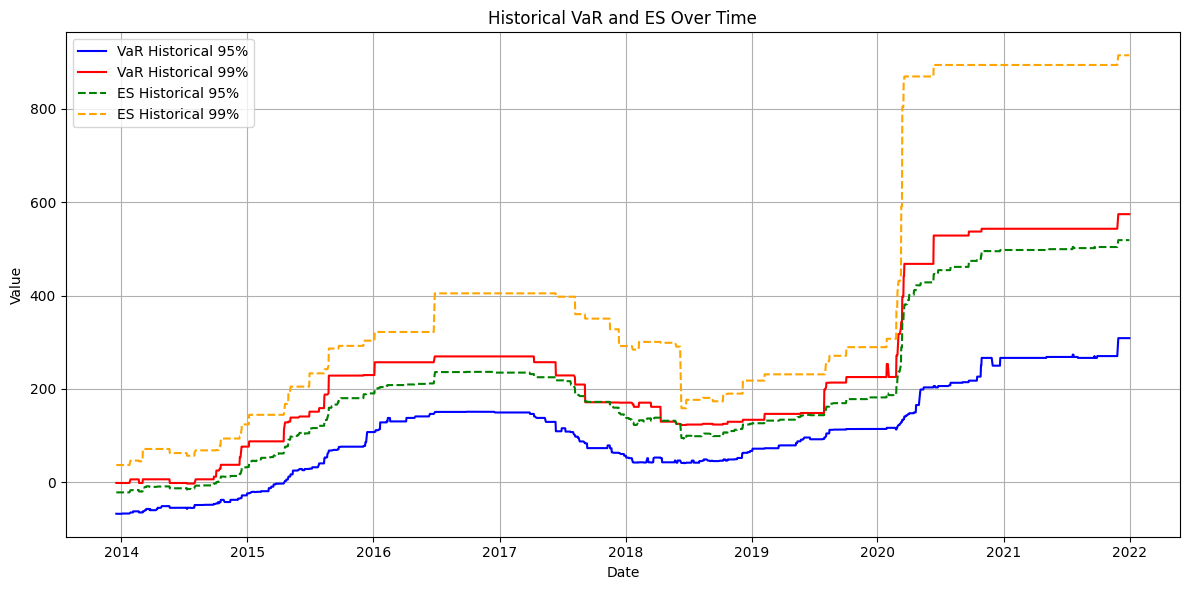

In [31]:
# Plot Historical VaR and ES over time
plt.figure(figsize=(12, 6))

# Plot VaR Historical 95% and 99%
plt.plot(var_results_df['Date'], var_results_df['VaR Historical 95%'], label='VaR Historical 95%', color='blue')
plt.plot(var_results_df['Date'], var_results_df['VaR Historical 99%'], label='VaR Historical 99%', color='red')

# Plot ES Historical 95% and 99%
plt.plot(es_results_df['Date'], es_results_df['ES Historical 95%'], label='ES Historical 95%', color='green', linestyle='--')
plt.plot(es_results_df['Date'], es_results_df['ES Historical 99%'], label='ES Historical 99%', color='orange', linestyle='--')

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Historical VaR and ES Over Time')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Create subplots for all indices
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# S&P 500
sp500_returns = main_df['C_S&P500_Returns'].dropna()
mu_sp500 = sp500_returns.mean()
sigma_sp500 = sp500_returns.std()
x_sp500 = np.linspace(mu_sp500 - 4*sigma_sp500, mu_sp500 + 4*sigma_sp500, 100)
ax1.hist(sp500_returns, bins=500, density=True, alpha=0.3, color='grey', label='Histogram')
ax1.plot(x_sp500, st.norm.pdf(x_sp500, mu_sp500, sigma_sp500), 'r-', lw=2, label='Normal')
# Add t-distributions
for df in [3, 4, 5, 6]:
    s = sigma_sp500 / np.sqrt(df/(df-2))
    ax1.plot(x_sp500, st.t.pdf((x_sp500-mu_sp500)/s, df)/s, '--', lw=1, label=f't-dist (df={df})')
ax1.set_title('S&P500 Returns Distribution')
ax1.legend()
ax1.grid(True)

# DAX40
dax_returns = main_df['C_Dax40_Returns'].dropna()
mu_dax = dax_returns.mean()
sigma_dax = dax_returns.std()
x_dax = np.linspace(mu_dax - 4*sigma_dax, mu_dax + 4*sigma_dax, 100)
ax2.hist(dax_returns, bins=500, density=True, alpha=0.3, color='grey', label='Histogram')
ax2.plot(x_dax, st.norm.pdf(x_dax, mu_dax, sigma_dax), 'r-', lw=2, label='Normal')
# Add t-distributions
for df in [3, 4, 5, 6]:
    s = sigma_dax / np.sqrt(df/(df-2))
    ax2.plot(x_dax, st.t.pdf((x_dax-mu_dax)/s, df)/s, '--', lw=1, label=f't-dist (df={df})')
ax2.set_title('DAX40 Returns Distribution')
ax2.legend()
ax2.grid(True)

# NIKKEI
nikkei_returns = main_df['C_Nikkei_Returns'].dropna()
mu_nikkei = nikkei_returns.mean()
sigma_nikkei = nikkei_returns.std()
x_nikkei = np.linspace(mu_nikkei - 4*sigma_nikkei, mu_nikkei + 4*sigma_nikkei, 100)
ax3.hist(nikkei_returns, bins=500, density=True, alpha=0.3, color='grey', label='Histogram')
ax3.plot(x_nikkei, st.norm.pdf(x_nikkei, mu_nikkei, sigma_nikkei), 'r-', lw=2, label='Normal')
# Add t-distributions
for df in [3, 4, 5, 6]:
    s = sigma_nikkei / np.sqrt(df/(df-2))
    ax3.plot(x_nikkei, st.t.pdf((x_nikkei-mu_nikkei)/s, df)/s, '--', lw=1, label=f't-dist (df={df})')
ax3.set_title('NIKKEI Returns Distribution')
ax3.legend()
ax3.grid(True)

# EU Bond
bond_returns = main_df['Interest_Bond_daily_rate'].dropna()
mu_bond = bond_returns.mean()
sigma_bond = bond_returns.std()
x_bond = np.linspace(mu_bond - 4*sigma_bond, mu_bond + 4*sigma_bond, 100)
ax4.hist(bond_returns, bins=500, density=True, alpha=0.3, color='grey', label='Histogram')
ax4.plot(x_bond, st.norm.pdf(x_bond, mu_bond, sigma_bond), 'r-', lw=2, label='Normal')
# Add t-distributions
for df in [3, 4, 5, 6]:
    s = sigma_bond / np.sqrt(df/(df-2))
    ax4.plot(x_bond, st.t.pdf((x_bond-mu_bond)/s, df)/s, '--', lw=1, label=f't-dist (df={df})')
ax4.set_title('EU Bond Returns Distribution')
ax4.legend()
ax4.grid(True)

plt.tight_layout()
plt.show()

## Historical simulation

VaR (S&P500) at 95.0% confidence level: 31.027729599999944
ES (S&P500) at 95.0% confidence level: 59.257054484375004


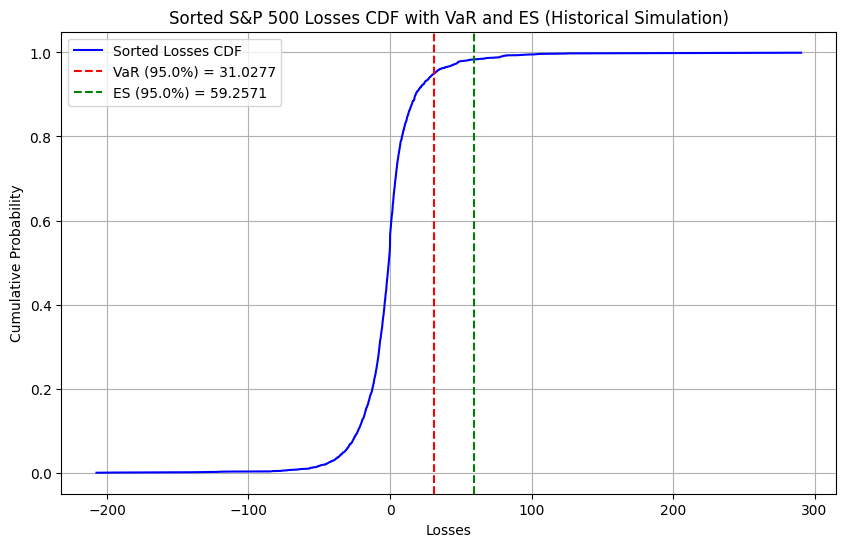

In [ ]:
# Define the confidence level
confidence_level = 0.95

# Extract historical losses for S&P500 for the specified period
sp500_losses = main_df[(main_df['Date'] >= '2012-01-04') & (main_df['Date'] <= '2021-12-31')]['C_S&P500_Loss']

# Sort the losses in ascending order (smallest loss first, largest loss last)
sorted_losses = sp500_losses.sort_values()

# Calculate VaR at the specified confidence level
# This finds the value at the threshold separating the worst (1-confidence_level)% losses
VaR_sp500 = sorted_losses.quantile(confidence_level)

# Calculate ES (Expected Shortfall)
# This is the average of the losses that are greater than or equal to the VaR value
tail_sp_losses = sorted_losses[sorted_losses >= VaR_sp500]
ES_sp500 = tail_sp_losses.mean()

print(f"VaR (S&P500) at {confidence_level * 100}% confidence level: {VaR_sp500}")
print(f"ES (S&P500) at {confidence_level * 100}% confidence level: {ES_sp500}")

# Plot the sorted losses (Empirical Cumulative Distribution Function - CDF)
plt.figure(figsize=(10, 6))
# Plotting the empirical CDF: x-axis is loss value, y-axis is cumulative probability
plt.plot(sorted_losses.values, np.linspace(0, 1, len(sorted_losses), endpoint=False), label='Sorted Losses CDF', color='blue')

# Highlight VaR and ES on the graph
# VaR is the loss value at the confidence level percentile
plt.axvline(x=VaR_sp500, color='red', linestyle='--', label=f'VaR ({confidence_level * 100}%) = {VaR_sp500:.4f}')
# ES is the average loss in the tail beyond VaR
plt.axvline(x=ES_sp500, color='green', linestyle='--', label=f'ES ({confidence_level * 100}%) = {ES_sp500:.4f}')

# Add labels, title, and legend
plt.xlabel('Losses')
plt.ylabel('Cumulative Probability')
plt.title('Sorted S&P 500 Losses CDF with VaR and ES (Historical Simulation)')
plt.legend()
plt.grid(True)
plt.show()

VaR (DAX40) at 95.0% confidence level: 199.3679999999997
ES (DAX40) at 95.0% confidence level: 314.866953125


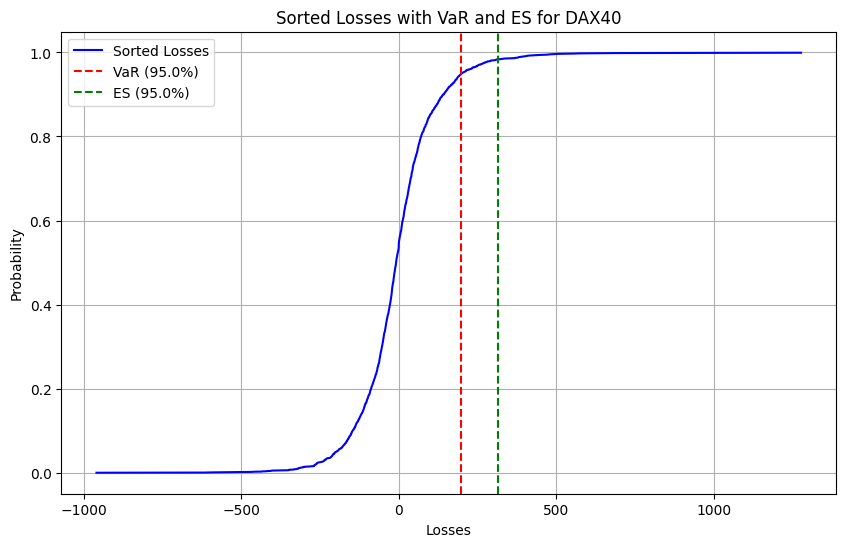

In [ ]:
confidence_level = 0.95
# Extract historical losses for DAX40
dax40_losses = main_df[(main_df['Date'] >= '2012-01-04') & (main_df['Date'] <= '2021-12-31')]['C_Dax40_Loss']

# Sort the losses in ascending order
sorted_dax40_losses = dax40_losses.sort_values()

# Calculate VaR at the specified confidence level
# This finds the value at the threshold separating the worst (1-confidence_level)% losses
VaR_dax40 = sorted_dax40_losses.quantile(confidence_level)

# Calculate ES (Expected Shortfall)
# This is the average of the losses that are greater than or equal to the VaR value
tail_dax_losses = sorted_dax40_losses[sorted_dax40_losses >= VaR_dax40]
ES_dax40 = tail_dax_losses.mean()

print(f"VaR (DAX40) at {confidence_level * 100}% confidence level: {VaR_dax40}")
print(f"ES (DAX40) at {confidence_level * 100}% confidence level: {ES_dax40}")

# Plot the sorted losses as a line graph
plt.figure(figsize=(10, 6))
plt.plot(sorted_dax40_losses.values, np.linspace(0, 1, len(sorted_dax40_losses), endpoint=False), label='Sorted Losses', color='blue')

# Highlight VaR and ES on the graph
plt.axvline(x=VaR_dax40, color='red', linestyle='--', label=f'VaR ({confidence_level * 100}%)')
plt.axvline(x=ES_dax40, color='green', linestyle='--', label=f'ES ({confidence_level * 100}%)')

# Add labels, title, and legend
plt.xlabel('Losses')
plt.ylabel('Probability')
plt.title('Sorted Losses with VaR and ES for DAX40')
plt.legend()
plt.grid()
plt.show()

VaR (Nikkei) at 95.0% confidence level: 3.0092212339999986
ES (Nikkei) at 95.0% confidence level: 4.61174921890625


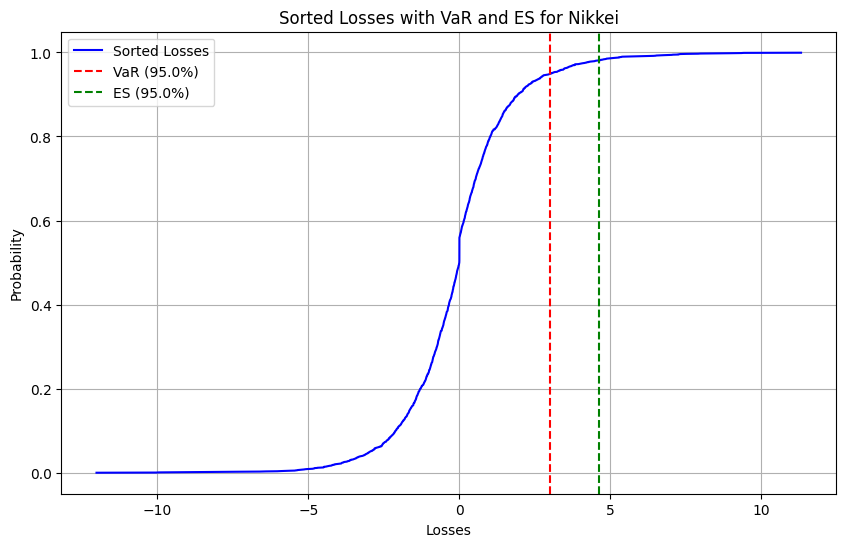

In [ ]:
confidence_level = 0.95

# Extract historical losses for Nikkei
nikkei_losses = main_df[(main_df['Date'] >= '2012-01-04') & (main_df['Date'] <= '2021-12-31')]['C_Nikkei_Loss']

# Sort the losses in ascending order
sorted_nikkei_losses = nikkei_losses.sort_values()

# Calculate VaR at the specified confidence level
# This finds the value at the threshold separating the worst (1-confidence_level)% losses
VaR_nikkei = sorted_nikkei_losses.quantile(confidence_level)

# Calculate ES (Expected Shortfall)
# This is the average of the losses that are greater than or equal to the VaR value
tail_nik_losses = sorted_nikkei_losses[sorted_nikkei_losses >= VaR_nikkei]
ES_nikkei = tail_nik_losses.mean()

print(f"VaR (Nikkei) at {confidence_level * 100}% confidence level: {VaR_nikkei}")
print(f"ES (Nikkei) at {confidence_level * 100}% confidence level: {ES_nikkei}")

# Plot the sorted losses as a line graph
plt.figure(figsize=(10, 6))
plt.plot(sorted_nikkei_losses.values, np.linspace(0, 1, len(sorted_nikkei_losses), endpoint=False), label='Sorted Losses', color='blue')

# Highlight VaR and ES on the graph
plt.axvline(x=VaR_nikkei, color='red', linestyle='--', label=f'VaR ({confidence_level * 100}%)')
plt.axvline(x=ES_nikkei, color='green', linestyle='--', label=f'ES ({confidence_level * 100}%)')

# Add labels, title, and legend
plt.xlabel('Losses')
plt.ylabel('Probability')
plt.title('Sorted Losses with VaR and ES for Nikkei')
plt.legend()
plt.grid()
plt.show()

## Backtesting VaR and ES

In this section, we perform backtesting on the calculated Value at Risk (VaR) and Expected Shortfall (ES) measures. Backtesting helps assess the accuracy and reliability of the risk models.

We will:
1.  **Calculate Violations:** Identify the days where the actual portfolio loss exceeded the predicted VaR.
2.  **Compare Actual vs. Expected Violations (VaR):** Group violations by year and compare the observed number of violations against the number expected based on the confidence level (alpha).
3.  **Compare Actual Shortfall vs. Predicted ES (ES):** For the days a violation occurred, compare the average actual loss (shortfall) against the predicted ES, grouped by year.
4.  **Visualize Violations:** Plot the occurrences of violations over time to visually inspect for clustering or patterns.

In [ ]:
def calculate_violations(actual_losses, var_predictions):
    """Checks for VaR violations."""
    return actual_losses > var_predictions

def backtest_var(violations, alpha, dates):
    """Compares actual vs. expected VaR violations yearly."""
    if not isinstance(violations, pd.Series):
        violations = pd.Series(violations, index=dates)
    elif violations.index.name != 'Date': # Ensure index is Date for grouping
         violations = violations.set_index(dates)
            
    violations_df = pd.DataFrame({'Violations': violations, 'Year': violations.index.year})
    yearly_violations = violations_df.groupby('Year')['Violations'].sum()
    yearly_counts = violations_df.groupby('Year')['Violations'].count()
    
    expected_violations = yearly_counts * (1 - alpha)
    
    summary = pd.DataFrame({
        'Actual Violations': yearly_violations,
        'Expected Violations': expected_violations,
        'Total Observations': yearly_counts
    })
    return summary

def backtest_es(actual_losses, violations, es_predictions, dates):
    """Compares actual average shortfall vs. predicted ES yearly."""
    # Ensure inputs are pandas Series with Date index
    if not isinstance(actual_losses, pd.Series):
        actual_losses = pd.Series(actual_losses, index=dates)
    elif actual_losses.index.name != 'Date':
        actual_losses = actual_losses.set_index(dates)
        
    if not isinstance(violations, pd.Series):
        violations = pd.Series(violations, index=dates)
    elif violations.index.name != 'Date':
        violations = violations.set_index(dates)
        
    if not isinstance(es_predictions, pd.Series):
        es_predictions = pd.Series(es_predictions, index=dates)
    elif es_predictions.index.name != 'Date':
        es_predictions = es_predictions.set_index(dates)

    results_df = pd.DataFrame({
        'Actual_Loss': actual_losses,
        'Violation': violations,
        'Predicted_ES': es_predictions,
        'Year': actual_losses.index.year
    })
    
    # Filter for violations
    violation_data = results_df[results_df['Violation']]
    
    # Calculate yearly averages
    yearly_avg_actual_shortfall = violation_data.groupby('Year')['Actual_Loss'].mean()
    yearly_avg_predicted_es = violation_data.groupby('Year')['Predicted_ES'].mean()
    yearly_violation_count = violation_data.groupby('Year').size()

    summary = pd.DataFrame({
        'Avg Actual Shortfall': yearly_avg_actual_shortfall,
        'Avg Predicted ES': yearly_avg_predicted_es,
        'Violation Count': yearly_violation_count
    })
    return summary

def plot_violations(violations, dates, title):
    """Plots VaR violations over time."""
    plt.figure(figsize=(15, 4))
    plt.plot(dates, violations, 'ro', markersize=4, alpha=0.7, label='Violation')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Violation (1=Yes, 0=No)')
    plt.yticks([0, 1])
    plt.grid(axis='y', linestyle='--')
    plt.show()

def run_backtesting(main_df, var_results_df, es_results_df):
    """Runs the backtesting process for VaR and ES models."""
    # Align main_df with var/es results (which start after the initial window)
    backtest_dates = var_results_df['Date']
    backtest_data = main_df[main_df['Date'].isin(backtest_dates)].set_index('Date')
    actual_losses = backtest_data['Portfolio_loss']

    # Confidence levels used
    alphas = [0.95, 0.99]
    alpha_indices = {0.95: 0, 0.99: 1} # Index mapping for results arrays

    # Iterate through models (columns in var_results_df/es_results_df)
    var_model_cols = [col for col in var_results_df.columns if col != 'Date']
    es_model_cols = [col for col in es_results_df.columns if col != 'Date']

    for i, model_name in enumerate(var_model_cols):
        print(f"\n--- Backtesting for Model: {model_name} ---")
        
        # Extract predictions for this model
        # Need to handle the fact that predictions are stored as arrays [pred_95, pred_99]
        var_preds_list = var_results_df[model_name].tolist()
        # Ensure alignment between var and es model columns
        if i < len(es_model_cols):
            es_preds_list = es_results_df[es_model_cols[i]].tolist()
        else:
            print(f"  Warning: No matching ES column found for {model_name}. Skipping ES backtest.")
            es_preds_list = None
        
        for alpha in alphas:
            alpha_idx = alpha_indices[alpha]
            print(f"\nConfidence Level: {alpha*100}%")
            
            # Extract predictions for the specific alpha
            # Handle potential errors if data isn't as expected (e.g., not a list/array)
            try:
                var_predictions = pd.Series([p[alpha_idx] for p in var_preds_list], index=backtest_dates)
                if es_preds_list:
                    es_predictions = pd.Series([p[alpha_idx] for p in es_preds_list], index=backtest_dates)
                else:
                    es_predictions = None
            except (TypeError, IndexError) as e:
                print(f"  Error extracting predictions for alpha={alpha}: {e}. Skipping.")
                continue
                
            # 1. Calculate Violations
            violations = calculate_violations(actual_losses, var_predictions)
            
            # 2. Backtest VaR
            var_summary = backtest_var(violations, alpha, backtest_dates)
            print("\nVaR Backtest Summary (Yearly):")
            display(var_summary)
            
            # 3. Backtest ES
            if es_predictions is not None:
                es_summary = backtest_es(actual_losses, violations, es_predictions, backtest_dates)
                print("\nES Backtest Summary (Yearly):")
                display(es_summary)
            
            # 4. Plot Violations
            plot_violations(violations, backtest_dates, f'VaR Violations for {model_name} (alpha={alpha})')


--- Backtesting for Model: VaR Normal ---

Confidence Level: 95.0%

VaR Backtest Summary (Yearly):


,Actual Violations,Expected Violations,Total Observations
Year,,,
2013,0,0.450000,9
2014,36,12.750000,255
2015,42,12.700000,254
2016,15,12.850000,257
2017,2,12.750000,255
2018,30,12.650000,253
2019,22,12.650000,253
2020,28,12.750000,255
2021,6,12.850000,257



ES Backtest Summary (Yearly):


,Avg Actual Shortfall,Avg Predicted ES,Violation Count
Year,,,
2014,-1.439252,-32.685796,36
2015,124.659196,55.414230,42
2016,206.405023,161.562034,15
2017,97.071873,147.575275,2
2018,109.137050,89.571891,30
2019,159.835983,117.548028,22
2020,449.919401,238.666033,28
2021,381.997453,356.167587,6


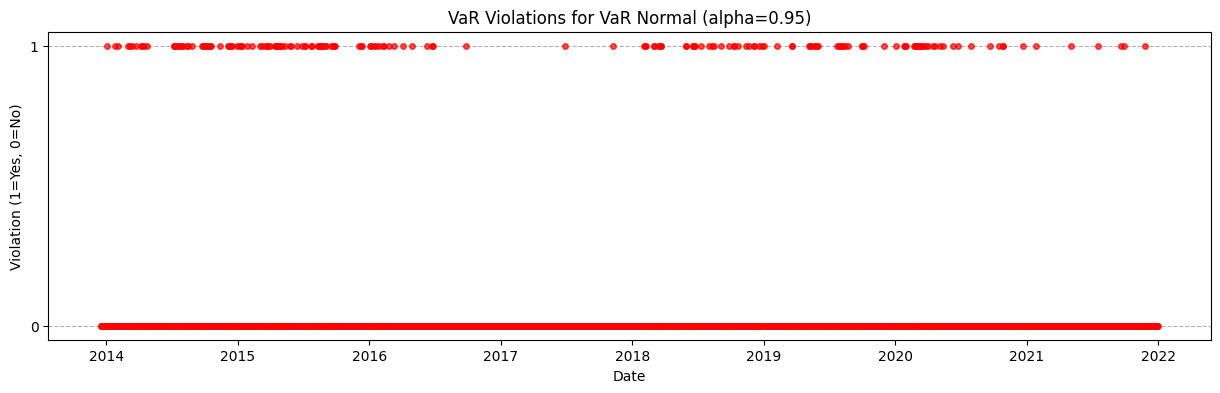


Confidence Level: 99.0%

VaR Backtest Summary (Yearly):


,Actual Violations,Expected Violations,Total Observations
Year,,,
2013,0,0.090000,9
2014,15,2.550000,255
2015,24,2.540000,254
2016,3,2.570000,257
2017,0,2.550000,255
2018,8,2.530000,253
2019,10,2.530000,253
2020,21,2.550000,255
2021,1,2.570000,257



ES Backtest Summary (Yearly):


,Avg Actual Shortfall,Avg Predicted ES,Violation Count
Year,,,
2014,54.945563,22.748344,15
2015,179.269677,125.123850,24
2016,414.186727,246.692438,3
2018,184.098915,150.720222,8
2019,219.054052,190.339133,10
2020,528.059948,336.882622,21
2021,677.561943,490.144292,1


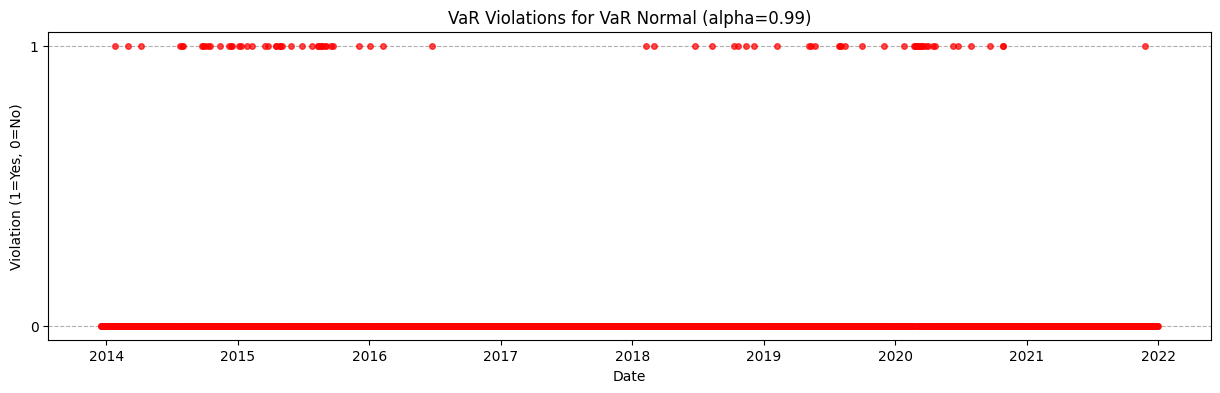


--- Backtesting for Model: VaR T3 ---

Confidence Level: 95.0%

VaR Backtest Summary (Yearly):


,Actual Violations,Expected Violations,Total Observations
Year,,,
2013,0,0.450000,9
2014,45,12.750000,255
2015,53,12.700000,254
2016,22,12.850000,257
2017,5,12.750000,255
2018,40,12.650000,253
2019,24,12.650000,253
2020,34,12.750000,255
2021,11,12.850000,257



ES Backtest Summary (Yearly):


,Avg Actual Shortfall,Avg Predicted ES,Violation Count
Year,,,
2014,-16.325153,-16.199090,45
2015,95.924412,75.648538,53
2016,168.334133,191.321948,22
2017,77.862005,174.806632,5
2018,89.202796,107.831465,40
2019,150.251249,138.309334,24
2020,398.553633,270.341163,34
2021,314.688592,394.567855,11


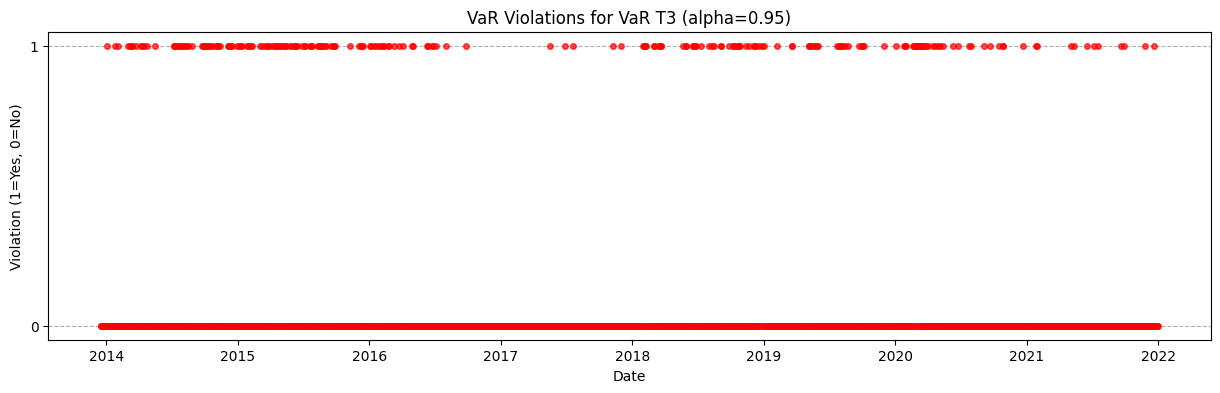


Confidence Level: 99.0%

VaR Backtest Summary (Yearly):


,Actual Violations,Expected Violations,Total Observations
Year,,,
2013,0,0.090000,9
2014,10,2.550000,255
2015,20,2.540000,254
2016,2,2.570000,257
2017,0,2.550000,255
2018,5,2.530000,253
2019,6,2.530000,253
2020,19,2.550000,255
2021,1,2.570000,257



ES Backtest Summary (Yearly):


,Avg Actual Shortfall,Avg Predicted ES,Violation Count
Year,,,
2014,83.192108,145.507223,10
2015,189.448560,279.405698,20
2016,516.617824,455.262694,2
2018,217.936123,295.102349,5
2019,259.647504,356.479833,6
2020,552.077454,563.082156,19
2021,677.561943,789.061059,1


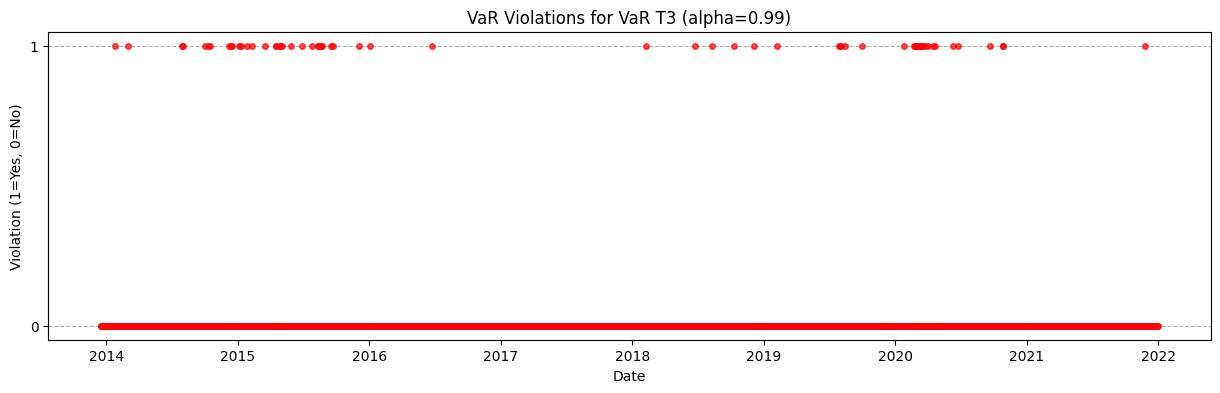


--- Backtesting for Model: VaR T4 ---

Confidence Level: 95.0%

VaR Backtest Summary (Yearly):


,Actual Violations,Expected Violations,Total Observations
Year,,,
2013,0,0.450000,9
2014,40,12.750000,255
2015,46,12.700000,254
2016,19,12.850000,257
2017,2,12.750000,255
2018,36,12.650000,253
2019,22,12.650000,253
2020,32,12.750000,255
2021,7,12.850000,257



ES Backtest Summary (Yearly):


,Avg Actual Shortfall,Avg Predicted ES,Violation Count
Year,,,
2014,-8.371004,-14.585637,40
2015,113.864567,79.817283,46
2016,183.384344,194.538708,19
2017,97.071873,174.192048,2
2018,96.712660,111.161282,36
2019,159.835983,141.479930,22
2020,418.164077,279.671484,32
2021,364.857352,401.831531,7


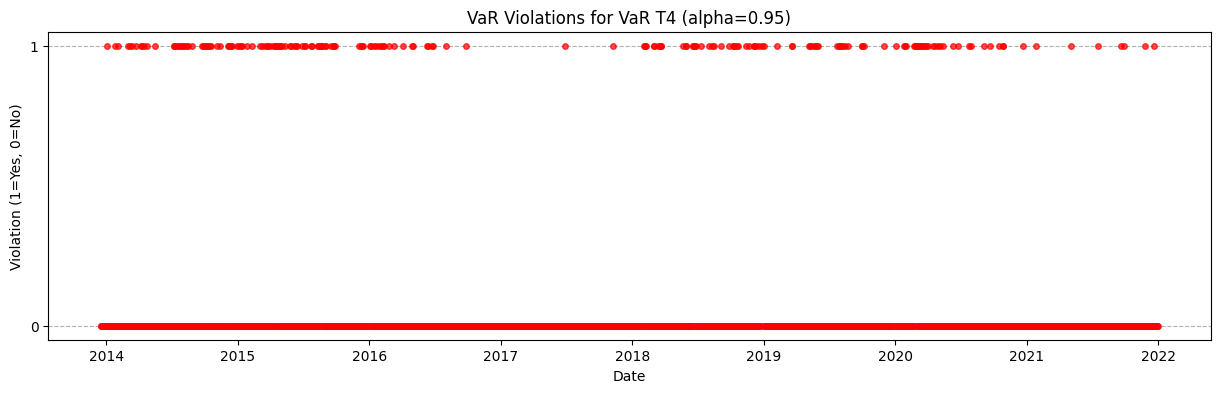


Confidence Level: 99.0%

VaR Backtest Summary (Yearly):


,Actual Violations,Expected Violations,Total Observations
Year,,,
2013,0,0.090000,9
2014,10,2.550000,255
2015,19,2.540000,254
2016,2,2.570000,257
2017,0,2.550000,255
2018,5,2.530000,253
2019,6,2.530000,253
2020,16,2.550000,255
2021,1,2.570000,257



ES Backtest Summary (Yearly):


,Avg Actual Shortfall,Avg Predicted ES,Violation Count
Year,,,
2014,83.192108,114.698859,10
2015,195.833698,242.151465,19
2016,516.617824,402.600127,2
2018,217.936123,257.925192,5
2019,259.647504,314.520925,6
2020,577.765915,483.703595,16
2021,677.561943,712.766469,1


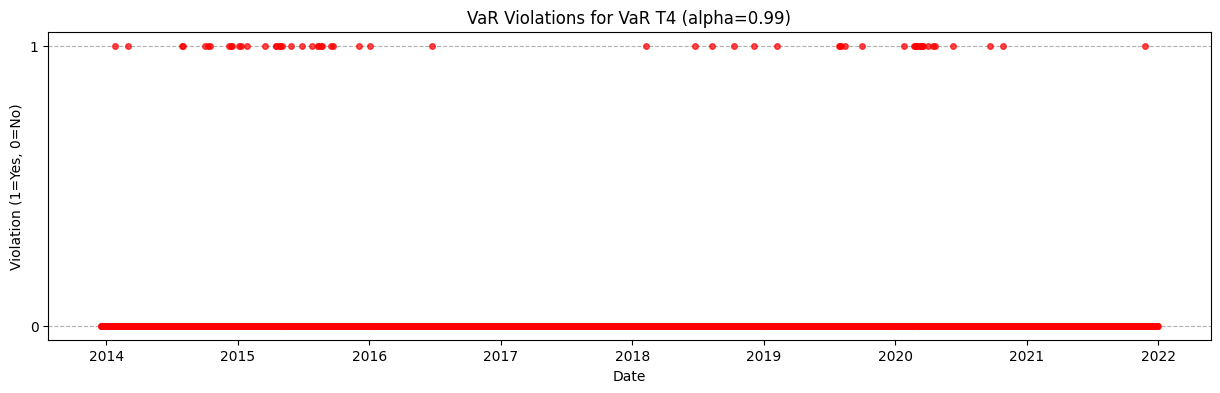


--- Backtesting for Model: VaR T5 ---

Confidence Level: 95.0%

VaR Backtest Summary (Yearly):


,Actual Violations,Expected Violations,Total Observations
Year,,,
2013,0,0.450000,9
2014,38,12.750000,255
2015,43,12.700000,254
2016,17,12.850000,257
2017,2,12.750000,255
2018,32,12.650000,253
2019,22,12.650000,253
2020,29,12.750000,255
2021,7,12.850000,257



ES Backtest Summary (Yearly):


,Avg Actual Shortfall,Avg Predicted ES,Violation Count
Year,,,
2014,-5.387540,-17.730283,38
2015,121.048052,75.122844,43
2016,193.015523,187.804521,17
2017,97.071873,170.755643,2
2018,105.076641,108.932830,32
2019,159.835983,138.390160,22
2020,441.117597,269.602730,29
2021,364.857352,396.196910,7


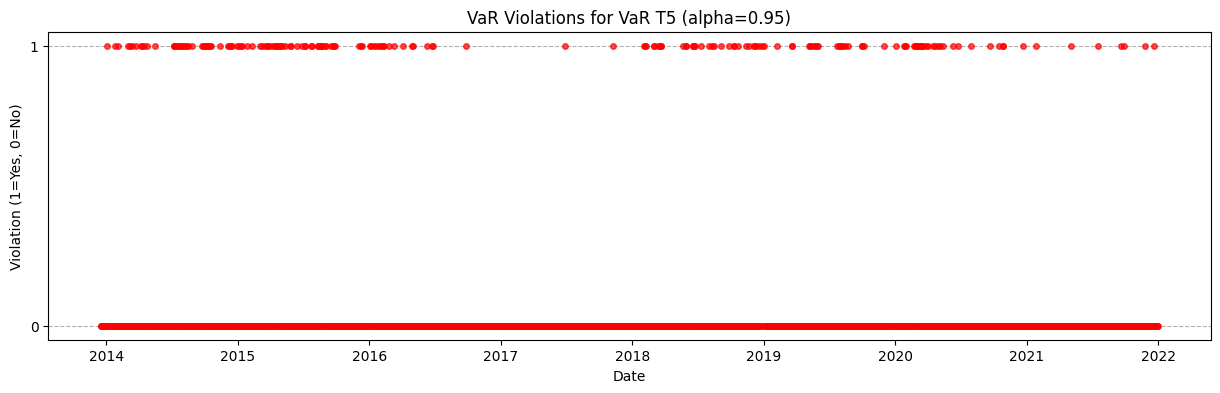


Confidence Level: 99.0%

VaR Backtest Summary (Yearly):


,Actual Violations,Expected Violations,Total Observations
Year,,,
2013,0,0.090000,9
2014,10,2.550000,255
2015,21,2.540000,254
2016,2,2.570000,257
2017,0,2.550000,255
2018,5,2.530000,253
2019,6,2.530000,253
2020,19,2.550000,255
2021,1,2.570000,257



ES Backtest Summary (Yearly):


,Avg Actual Shortfall,Avg Predicted ES,Violation Count
Year,,,
2014,83.192108,93.442281,10
2015,187.612109,212.960980,21
2016,516.617824,366.264997,2
2018,217.936123,232.274395,5
2019,259.647504,285.570905,6
2020,552.077454,465.155067,19
2021,677.561943,660.126159,1


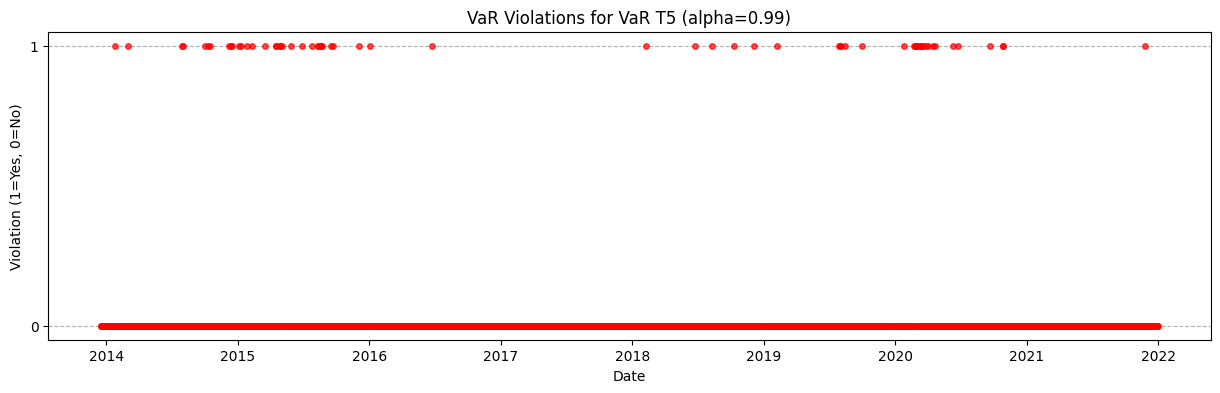


--- Backtesting for Model: VaR T6 ---

Confidence Level: 95.0%

VaR Backtest Summary (Yearly):


,Actual Violations,Expected Violations,Total Observations
Year,,,
2013,0,0.450000,9
2014,37,12.750000,255
2015,42,12.700000,254
2016,17,12.850000,257
2017,2,12.750000,255
2018,30,12.650000,253
2019,22,12.650000,253
2020,28,12.750000,255
2021,6,12.850000,257



ES Backtest Summary (Yearly):


,Avg Actual Shortfall,Avg Predicted ES,Violation Count
Year,,,
2014,-3.396420,-19.787888,37
2015,124.659196,73.033090,42
2016,193.015523,183.978413,17
2017,97.071873,167.412980,2
2018,109.137050,105.712199,30
2019,159.835983,135.384677,22
2020,449.919401,263.625227,28
2021,381.997453,388.551739,6


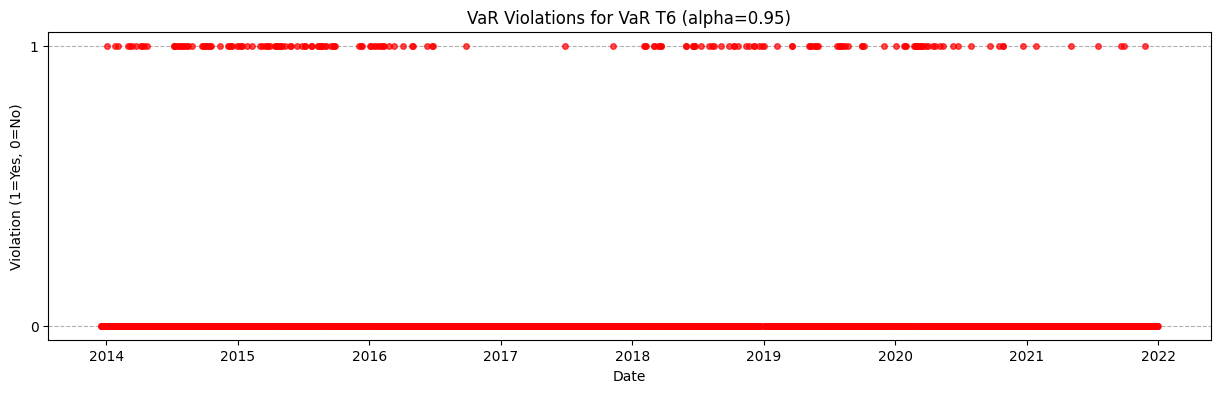


Confidence Level: 99.0%

VaR Backtest Summary (Yearly):


,Actual Violations,Expected Violations,Total Observations
Year,,,
2013,0,0.090000,9
2014,11,2.550000,255
2015,21,2.540000,254
2016,2,2.570000,257
2017,0,2.550000,255
2018,6,2.530000,253
2019,6,2.530000,253
2020,19,2.550000,255
2021,1,2.570000,257



ES Backtest Summary (Yearly):


,Avg Actual Shortfall,Avg Predicted ES,Violation Count
Year,,,
2014,76.742587,79.126445,11
2015,187.612109,194.844448,21
2016,516.617824,342.863704,2
2018,203.933896,214.719033,6
2019,259.647504,266.925921,6
2020,552.077454,439.405856,19
2021,677.561943,626.223670,1


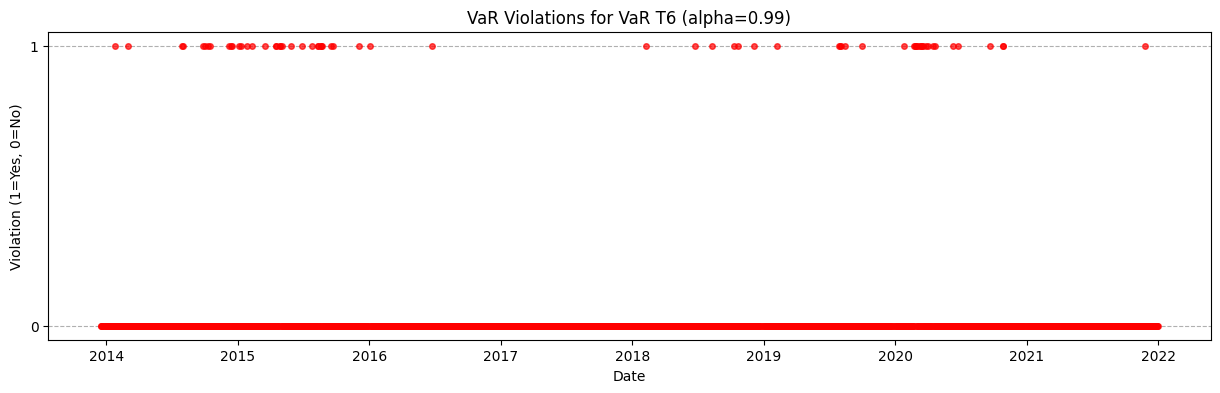

In [ ]:
# Call the backtesting function with the required dataframes
run_backtesting(main_df, var_results_df, es_results_df)

### Backtesting Interpretation

Review the tables and plots above:

*   **VaR Backtest:** Compare 'Actual Violations' to 'Expected Violations' each year. Significant deviations might indicate issues with the VaR model's calibration. If actual violations consistently exceed expected, the model underestimates risk. If they are consistently lower, it might be too conservative.
*   **ES Backtest:** Compare 'Avg Actual Shortfall' to 'Avg Predicted ES'. If the actual average shortfall during violations is consistently higher than the predicted ES, the model underestimates the severity of tail losses.
*   **Violation Plots:** Look for patterns. Ideally, violations should be randomly distributed. Clustering of violations suggests the model fails to adapt quickly to changing market volatility (violation dependence).